In [12]:
# %load_ext nb_black
# %load_ext lab_black

This is my project for computational intelligence based on kaggle dataset of monkeys.

In [13]:
# Import packages


import os
from pathlib import Path

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.layers import (
    Conv2D,
    Activation,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

Set data folders

In [14]:
data_folder = "data"
training_directory = os.path.join(data_folder, "training", "training")
test_directory = os.path.join(data_folder, "validation", "validation")
labels_file = os.path.join(data_folder, "monkey_labels.txt")

Read labels

In [15]:
labels_df = pd.read_csv(labels_file)
labels_df = labels_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
labels_df.columns = labels_df.columns.str.strip()
labels = labels_df["Common Name"]

Read images from files

In [16]:
def convert_image_to_vector(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size)
    return resized_image


def convert_image_to_vector_rgb(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size)
    img_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb


def convert_image_to_vector_cubic(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    return resized_image


def convert_image_to_vector_both(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    img_rgb_cubic = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb_cubic


def normalize(input_image):
    mean, std = input_image.mean(), input_image.std()
    input_image = (input_image - mean) / std
    return input_image


def process_image(file):
    image_file = cv2.imread(file)
    image_pixels = convert_image_to_vector_both(image_file, size=(32, 32))
    image_pixels = normalize(image_pixels)
    image_label = file.split(os.path.sep)[-2][1]
    return image_pixels, image_label

In [17]:
training_images = []
training_images_flattened = []
training_labels = []

for path in Path(training_directory).rglob("*.jpg"):
    image, label = process_image(str(path))
    training_images.append(image)
    training_images_flattened.append(image.flatten())
    training_labels.append(label)

test_images = []
test_images_flattened = []
test_labels = []

for path in Path(test_directory).rglob("*.jpg"):
    image, label = process_image(str(path))
    test_images.append(image)
    test_labels.append(label)
    test_images_flattened.append(image.flatten())

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


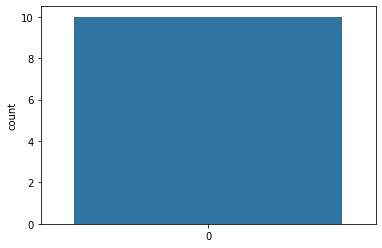

In [18]:
df = pd.DataFrame()
df["labels"] = training_labels
lab = df["labels"]
counts = lab.value_counts()
sns.countplot(data=counts)
print(labels)

In [19]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images_flattened = np.array(test_images_flattened)
training_labels_for_flattened = training_labels

training_images = np.array(training_images)
training_labels = np.array(training_labels)
training_images_flattened = np.array(training_images_flattened)
test_labels_for_flattened = test_labels

num_classes = len(np.unique(training_labels))
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(training_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = np_utils.to_categorical(test_labels, num_classes)
training_labels = np_utils.to_categorical(training_labels, num_classes)

In [20]:
# LINEAR REGRESSION
# print(training_images_flattened)
# # print(training_labels_for_flattened)
# # print(test_images_flattened)
# # print(test_labels_for_flattened)
# normalzed = normalize(training_images_flattened)
# print(normalzed)
# # data = pd.DataFrame(training_images_flattened).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
# # test_data = pd.DataFrame(test_images_flattened).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
# lin_reg = LinearRegression()
# lin_reg.fit(normalize(training_images_flattened), training_labels_for_flattened)
# predictions = lin_reg.predict(test_images_flattened)
#
# plt.scatter(training_images_flattened, training_labels_for_flattened, color="black")
# plt.plot(test_images_flattened, test_labels_for_flattened, color="blue", linewidth=3)
#
# plt.xticks(())
# plt.yticks(())
#
# plt.show()

# SGD
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(training_images_flattened, training_labels_for_flattened)
y_pred = sgd_clf.predict(test_images_flattened)
print('Percentage correct: ', 100*np.sum(y_pred == test_labels_for_flattened)/len(test_labels_for_flattened))

Percentage correct:  47.05882352941177


In [21]:
# TEST KNN classifier
model7 = KNeighborsClassifier(n_neighbors=7)
model14 = KNeighborsClassifier(n_neighbors=14)
model2 = KNeighborsClassifier(n_neighbors=2)
model1 = KNeighborsClassifier(n_neighbors=1)

model1.fit(training_images_flattened, training_labels)
model2.fit(training_images_flattened, training_labels)
model7.fit(training_images_flattened, training_labels)
model14.fit(training_images_flattened, training_labels)

acc1 = model1.score(test_images_flattened, test_labels)
acc2 = model2.score(test_images_flattened, test_labels)
acc7 = model7.score(test_images_flattened, test_labels)
acc14 = model14.score(test_images_flattened, test_labels)

print("Accuracy for 1n: {:.2f}%".format(acc1 * 100))
print("Accuracy for 2n: {:.2f}%".format(acc2 * 100))
print("Accuracy for 7n: {:.2f}%".format(acc7 * 100))
print("Accuracy for 14n: {:.2f}%".format(acc14 * 100))


Accuracy for 1n: 43.01%
Accuracy for 2n: 18.01%
Accuracy for 7n: 16.91%
Accuracy for 14n: 9.19%


In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          1

In [23]:
es = EarlyStopping(
    monitor="loss",
    mode="min",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    "Best_model.h5",
    save_best_only=True,
    monitor = "loss",
    mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor = "loss",
    factor = 0.3,
    patience = 3,
    min_lr = 1e-5,
    mode = "min",
    verbose = 1
)

model.fit(
    training_images,
    training_labels,
    epochs=30,
    callbacks=[checkpoint_cb, es, reduce_lr]
)
model.save("Model323232firstsimple"+".h5")

Epoch 1/30
35/35 [==============================] - 2s 17ms/step - loss: 2.2844 - accuracy: 0.1351
Ep

Test accuracy

In [24]:
test_loss, test_acc = model.evaluate(
    test_images,
    test_labels,
    verbose=2
)
print("\nTest accuracy:", test_acc)

9/9 - 0s - loss: 1.5558 - accuracy: 0.6507

Test accuracy: 0.6507353186607361


Test on one image

In [25]:
n = 200
test_image = test_images[n]
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image, batch_size=1)
print(labels[np.argmax(prediction)])
print(labels)

common_squirrel_monkey
0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


In [26]:
IMG_SIZE = 32
size = (IMG_SIZE,IMG_SIZE)

datagenerator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest",
    validation_split=0.2
)

train_set = datagenerator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="training",
    shuffle = True,
    class_mode="categorical"
)

val_set = datagenerator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="validation",
    shuffle = True,
    class_mode="categorical"
)


test_set = datagenerator.flow_from_directory(
    test_directory,
    target_size = size,
    batch_size = 32,
    seed = 42,
    class_mode = "categorical",
    shuffle = False
)

from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3

Found 881 images belonging to 10 classes.
Found 217 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [27]:
image_generator_model = Sequential()
image_generator_model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = "imagenet"))
image_generator_model.add(GlobalAveragePooling2D())
image_generator_model.add(Flatten())
image_generator_model.add(Dense(512, activation = "relu", bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
image_generator_model.add(Dropout(0.7))
image_generator_model.add(Dense(10, activation = "softmax"))

image_generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1, 1, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 11,575,609
Trainable params: 11,488,306
Non-trainable params: 87,303
_____________________________________

In [28]:
keras.utils.plot_model(image_generator_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [29]:
EPOCHS = 30
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

image_generator_model.compile(
    optimizer = "adam",
    loss ="categorical_crossentropy",
    metrics = ["acc"]
)


image_generator_model.fit(
    train_set,
    validation_data = val_set,
    epochs= EPOCHS,
    batch_size = 32,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VALID,
    callbacks=[es, reduce_lr]
)
print(image_generator_model.evaluate(test_set))
image_generator_model.save("Model323232second"+".h5")

Epoch 1/30
27/27 [==============================] - 36s 799ms/step - loss: 3.0826 - acc: 0.0916 - val_loss: 2.3512 - val_acc: 0.0938

In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(training_directory,
                                                    target_size=(32, 32),
                                                    batch_size= 64,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_directory,
                                                  target_size=(32, 32),
                                                  batch_size=64,
                                                  seed=1,
                                                  shuffle=False,
                                                  class_mode="categorical")

train_num = train_generator.samples
validation_num = validation_generator.samples

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [31]:
num_classes = 10

monkey_model = Sequential()
monkey_model.add(Conv2D(32,(3,3), input_shape=(32,32,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(32,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(64,(3,3), padding="same", activation="relu"))
monkey_model.add(Conv2D(64,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Dropout(0.25))
monkey_model.add(Flatten())
monkey_model.add(Dense(512))
monkey_model.add(Activation("relu"))
monkey_model.add(Dropout(0.5))
monkey_model.add(Dense(num_classes))
monkey_model.add(Activation("softmax"))

In [32]:
monkey_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)
monkey_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 64)         

In [33]:
callbacks_list = [es, reduce_lr]
batch_size = 64

monkey_model.fit(
    train_generator,
    steps_per_epoch = train_num // batch_size,
    epochs = 50,
    validation_data = train_generator,
    validation_steps = validation_num // batch_size,
    callbacks = callbacks_list,
    verbose = 1
)
monkey_model.save("Model323232third"+".h5")

Epoch 1/50
17/17 [==============================] - 18s 1s/step - loss: 2.3071 - acc: 0.0927 - val_loss: 2.2756 - val_acc: 0.1562

In [34]:
monkey_model.evaluate(validation_generator)

5/5 [==============================] - 4s 683ms/step - loss: 1.2795 - acc: 0.5257


[1.2795192003250122, 0.5257353186607361]